# IMECA's PM2.5 Cuauh por día (v3)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
import warnings
warnings.simplefilter("ignore")

plt.style.use('bmh')

In [2]:
def mape(y_true, y_pred):
    y_true, y_pred=np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

def smape(y_true,y_pred):
    return ((y_true - y_pred).abs() / (y_true.abs() + y_pred.abs())).mean() * 200

In [3]:
def imeca_calculation(a):
    imeca = []
    for e in a:
        e=round(e)
        if (e>0)&(e<=40):
            k= (50-0)/(40-0)
            im=k*(e-0) + 0
            imeca.append(round(im))

        elif (e>=41) & (e<=75):
            k=(100-51)/(75-41)
            im=k*(e-41) + 51
            imeca.append(round(im))

        elif (e>=76) & (e<=214):
            k=(150-101)/(214-76)
            im=k*(e-76) + 101
            imeca.append(round(im))

        elif (e>=215) & (e<=354):
            k=(200-151)/(354-215)
            im=k*(e-215) + 151
            imeca.append(round(im))

        elif (e>=355) & (e<=424):
            k=(300-201)/(424-355)
            im=k*(e-355) + 201
            imeca.append(round(im))

    return imeca

In [4]:
def categorizando(df):
    lst=[]
    for e in df:
        if (e>=0) & (e<50):
            lst.append('Buena')
        elif (e>=50) & (e<100):
            lst.append('Regular')
        elif (e>=100) & (e<150):
            lst.append('Mala')
        elif (e>=150) & (e<200):
            lst.append('Muy mala')
        else:
            lst.append('Ya vete de aquí woe')
    return lst

In [5]:
def comparando_categorias(a,b):
    lst=[]
    for e in range(len(a)):
        if a[e] == b[e]:
            lst.append(1)
        else:
            lst.append(0)
    return lst

### Leyendo CSV de IMECA's directos

In [6]:
cuauh_imeca_real = pd.read_excel("../data_aircdmx/imeca2019.xls")

In [7]:
cuauh_imeca_real.Hora[cuauh_imeca_real.Hora==24] = 00
cuauh_imeca_real.Fecha=cuauh_imeca_real.Fecha.apply(str)
cuauh_imeca_real.Fecha=cuauh_imeca_real.Fecha.apply(lambda x: x.replace(' 00:00:00',''))
cuauh_imeca_real['DATETIME']=cuauh_imeca_real.Fecha + ' ' + cuauh_imeca_real.Hora.apply(str)+':00:00'
#df.DATETIME=df.DATETIME.apply(lambda x: x.replace(' 00:00:00',''))
cuauh_imeca_real.DATETIME=pd.to_datetime(cuauh_imeca_real.DATETIME)

In [8]:
cuauh_imeca_real.DATETIME.tail()

7291   2019-10-31 20:00:00
7292   2019-10-31 21:00:00
7293   2019-10-31 22:00:00
7294   2019-10-31 23:00:00
7295   2019-10-31 00:00:00
Name: DATETIME, dtype: datetime64[ns]

In [9]:
cuauh_imeca_real=cuauh_imeca_real[['DATETIME','Centro PM25']]
cuauh_imeca_real=cuauh_imeca_real.set_index('DATETIME')

cuauh_imeca_mean=cuauh_imeca_real.groupby(pd.TimeGrouper('D')).mean()
cuauh_imeca_max=cuauh_imeca_real.groupby(pd.TimeGrouper('D')).max()
cuauh_imeca_median=cuauh_imeca_real.groupby(pd.TimeGrouper('D')).median()

## Ejecución del modelo

In [10]:
cuauh_clean_max = pd.read_csv("../data_clean/cuauh_pm25_max_clean_v3.csv",index_col=[0])
cuauh_clean_median = pd.read_csv("../data_clean/cuauh_pm25_median_clean_v3.csv",index_col=[0])
cuauh_clean_mean = pd.read_csv("../data_clean/cuauh_pm25_mean_clean_v3.csv",index_col=[0])

In [11]:
split_date2='2019-01-01'
split_date1='2015-11-01'

#### Para el valor Máximo ######
train=cuauh_clean_max[(cuauh_clean_max.index>=split_date1)&(cuauh_clean_max.index<split_date2)].copy()
test=cuauh_clean_max[cuauh_clean_max.index>split_date2].copy()

#### Para la Mediana ######
train2=cuauh_clean_median[(cuauh_clean_median.index>=split_date1)&(cuauh_clean_median.index<split_date2)].copy()
test2=cuauh_clean_median[cuauh_clean_median.index>split_date2].copy()

#### Para la Mean ######
train3=cuauh_clean_mean[(cuauh_clean_mean.index>=split_date1)&(cuauh_clean_mean.index<split_date2)].copy()
test3=cuauh_clean_mean[cuauh_clean_mean.index>split_date2].copy()

### Preparando para fbprophet

In [12]:
train=train.reset_index().rename(columns={'DATETIME':'ds','HGM':'y'})
test=test.reset_index().rename(columns={'DATETIME':'ds','HGM':'y'})

train.ds=pd.to_datetime(train.ds)
test.ds=pd.to_datetime(test.ds)
test=test.dropna()
###############################################################################
train2=train2.reset_index().rename(columns={'DATETIME':'ds','HGM':'y'})
test2=test2.reset_index().rename(columns={'DATETIME':'ds','HGM':'y'})

train2.ds=pd.to_datetime(train2.ds)
test2.ds=pd.to_datetime(test2.ds)
test2=test2.dropna()
###############################################################################
train3=train3.reset_index().rename(columns={'DATETIME':'ds','HGM':'y'})
test3=test3.reset_index().rename(columns={'DATETIME':'ds','HGM':'y'})

train3.ds=pd.to_datetime(train3.ds)
test3.ds=pd.to_datetime(test3.ds)
test3=test3.dropna()

## Modelo 1

In [13]:
modelo=Prophet(n_changepoints=2,
               #growth='linear',
               #holidays=holidays_df,
               #changepoints=['2016-01-01','2017-02-01','2018-01-01','2018-12-31'],
               changepoint_prior_scale=0.65,
               #daily_seasonality=True,
               #yearly_seasonality=15,
               #weekly_seasonality=True,
               #daily_seasonality=False,
               #yearly_seasonality=True,
               #seasonality_prior_scale = 15,
               #seasonality_mode='multiplicative',
               #interval_width=0.95
              ).fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [14]:
pred=modelo.predict(test)

In [15]:
mape(test.y, pred.yhat), smape(test.y, pred.yhat)

(29.969175496181254, 26.91819220044386)

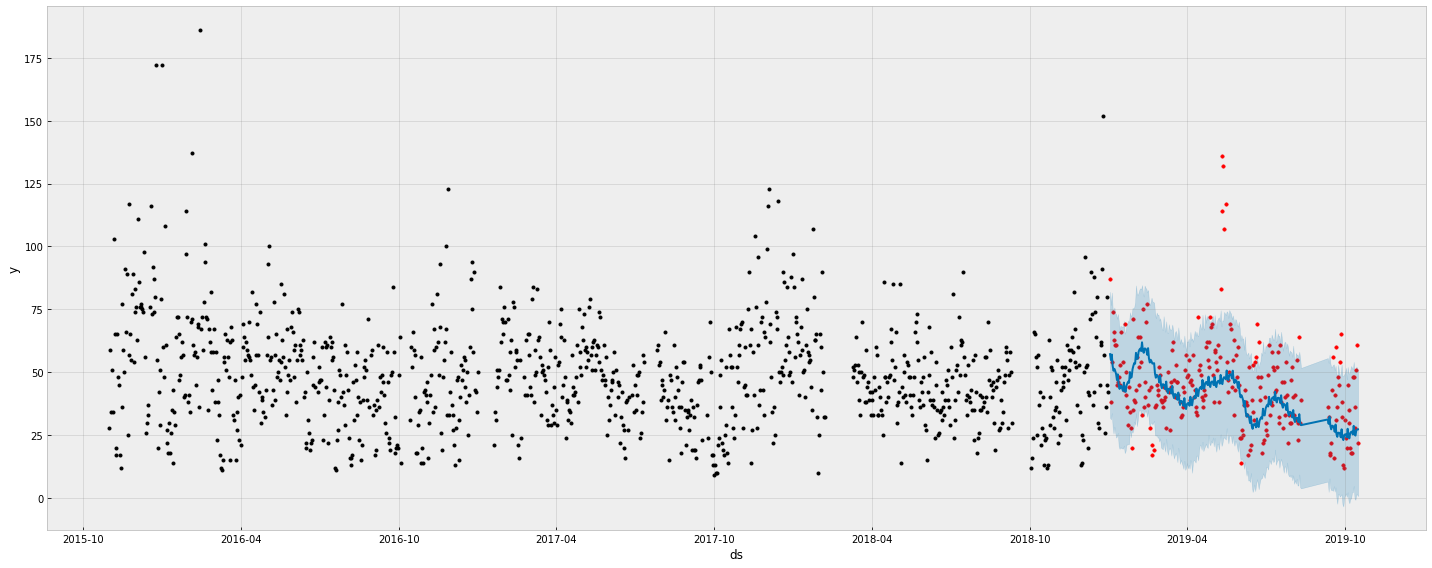

In [16]:
f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(20)
ax.scatter(test.ds, test.y, color='r',s=12)
fig=modelo.plot(pred, ax)

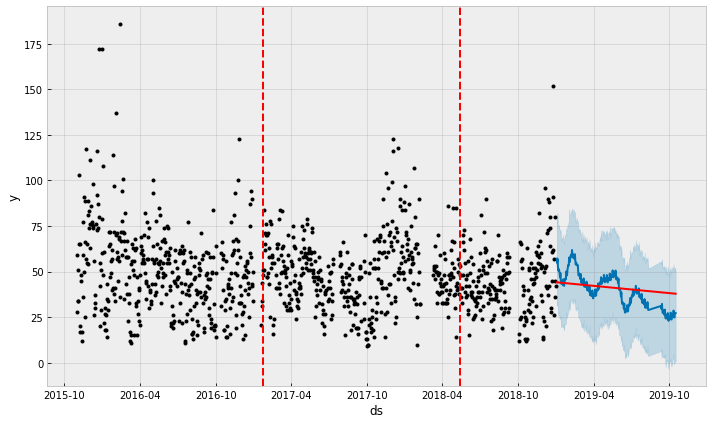

In [17]:
from fbprophet.plot import add_changepoints_to_plot
#ploteando change_pints del modelo
fig = modelo.plot(pred)
a = add_changepoints_to_plot(fig.gca(), modelo, pred)

In [18]:
pred.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-02,44.166876,31.871091,81.965348,44.166876,44.166876,13.009202,13.009202,13.009202,0.447700,0.447700,0.447700,12.561502,12.561502,12.561502,0.0,0.0,0.0,57.176078
1,2019-01-03,44.145070,31.240206,76.713179,44.145070,44.145070,10.675950,10.675950,10.675950,-0.894931,-0.894931,-0.894931,11.570881,11.570881,11.570881,0.0,0.0,0.0,54.821020
2,2019-01-04,44.123265,33.739899,81.688413,44.123265,44.123265,12.904744,12.904744,12.904744,2.397849,2.397849,2.397849,10.506896,10.506896,10.506896,0.0,0.0,0.0,57.028009
3,2019-01-05,44.101459,28.216579,75.335307,44.101459,44.101459,8.474288,8.474288,8.474288,-0.914928,-0.914928,-0.914928,9.389215,9.389215,9.389215,0.0,0.0,0.0,52.575747
4,2019-01-06,44.079654,25.538495,74.072683,44.079654,44.079654,6.500246,6.500246,6.500246,-1.738870,-1.738870,-1.738870,8.239116,8.239116,8.239116,0.0,0.0,0.0,50.579900


## Modelo 2

In [99]:
modelo2=Prophet(#n_changepoints=2,
               #growth='linear',
               #holidays=holidays_df,
               #changepoints=['2016-01-01','2017-02-01','2018-01-01','2018-12-31'],
               #changepoint_prior_scale=0.65,
               #daily_seasonality=True,
               #yearly_seasonality=15,
               #weekly_seasonality=True,
               #daily_seasonality=False,
               #yearly_seasonality=True,
               #seasonality_prior_scale = 15,
               #seasonality_mode='multiplicative'
               #interval_width=0.95
              ).fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [100]:
pred2=modelo2.predict(test)

In [101]:
mape(test.y, pred2.yhat), smape(test.y, pred2.yhat)

(33.11050460677733, 25.664736261546985)

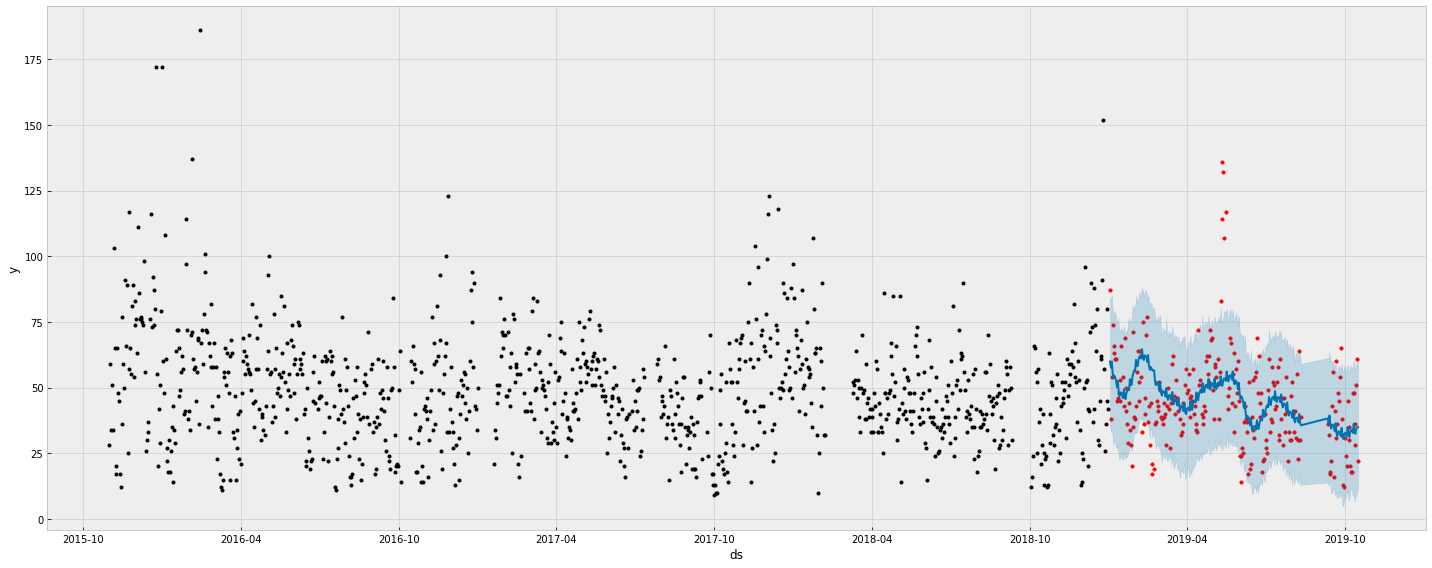

In [102]:
f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(20)
ax.scatter(test.ds, test.y, color='r',s=12)
fig=modelo.plot(pred2, ax)

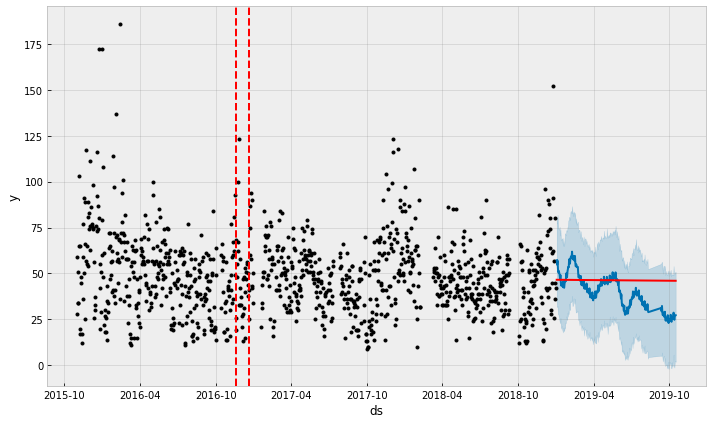

In [103]:
from fbprophet.plot import add_changepoints_to_plot
#ploteando change_pints del modelo
fig = modelo.plot(pred)
a = add_changepoints_to_plot(fig.gca(), modelo2, pred2)

In [104]:
pred2.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-02,46.578787,36.260237,84.159655,46.578787,46.578787,13.351076,13.351076,13.351076,0.456999,0.456999,0.456999,12.894077,12.894077,12.894077,0.0,0.0,0.0,59.929863
1,2019-01-03,46.576903,32.914421,83.602251,46.576903,46.576903,11.050117,11.050117,11.050117,-0.929267,-0.929267,-0.929267,11.979384,11.979384,11.979384,0.0,0.0,0.0,57.627020
2,2019-01-04,46.575019,34.696904,85.204089,46.575019,46.575019,13.357189,13.357189,13.357189,2.368996,2.368996,2.368996,10.988193,10.988193,10.988193,0.0,0.0,0.0,59.932208
3,2019-01-05,46.573135,31.370810,79.797183,46.573135,46.573135,9.013876,9.013876,9.013876,-0.925233,-0.925233,-0.925233,9.939109,9.939109,9.939109,0.0,0.0,0.0,55.587011
4,2019-01-06,46.571251,27.817294,78.961582,46.571251,46.571251,7.126390,7.126390,7.126390,-1.726004,-1.726004,-1.726004,8.852394,8.852394,8.852394,0.0,0.0,0.0,53.697641


# Comparación directa de IMECA

## Comparación modelo 1

### Predicción

In [19]:
df_pred=pd.DataFrame(pred[['ds','yhat_upper']])
df_pred=df_pred.set_index('ds')

In [20]:
df_pred.head(10)

,yhat_upper
ds,
2019-01-02,81.965348
2019-01-03,76.713179
2019-01-04,81.688413
2019-01-05,75.335307
2019-01-06,74.072683
2019-01-07,75.756992
2019-01-08,73.512279
2019-01-09,73.165738
2019-01-10,71.278829


In [21]:
df_pred.shape

(254, 1)

In [22]:
df_pred.isnull().sum() #13 NANs
df_pred=df_pred.dropna()

In [23]:
df_pred.shape

(254, 1)

In [24]:
df_pred['imeca_pred']=imeca_calculation(df_pred.yhat_upper)
df_pred.head()

,yhat_upper,imeca_pred
ds,,
2019-01-02,81.965348,103
2019-01-03,76.713179,101
2019-01-04,81.688413,103
2019-01-05,75.335307,100
2019-01-06,74.072683,99


### Cuauh's IMECA real

In [25]:
cuauh_imeca_max.head()

,Centro PM25
DATETIME,
2019-01-01,131
2019-01-02,131
2019-01-03,103
2019-01-04,89
2019-01-05,98


In [26]:
df_comparison=df_pred.join(cuauh_imeca_max)[['yhat_upper','imeca_pred','Centro PM25']]
df_comparison.head(10)

,yhat_upper,imeca_pred,Centro PM25
ds,,,
2019-01-02,81.965348,103,131
2019-01-03,76.713179,101,103
2019-01-04,81.688413,103,89
2019-01-05,75.335307,100,98
2019-01-06,74.072683,99,96
2019-01-07,75.756992,101,91
2019-01-08,73.512279,99,88
2019-01-09,73.165738,97,82
2019-01-10,71.278829,94,81


In [27]:
df_comparison['categoria_pred']=categorizando(df_comparison.imeca_pred)
df_comparison['categoria_real']=categorizando(df_comparison['Centro PM25'])
df_comparison['comparacion_imecas']=comparando_categorias(df_comparison.categoria_pred,df_comparison.categoria_real)
df_comparison.head(10)

,yhat_upper,imeca_pred,Centro PM25,categoria_pred,categoria_real,comparacion_imecas
ds,,,,,,
2019-01-02,81.965348,103,131,Mala,Mala,1
2019-01-03,76.713179,101,103,Mala,Mala,1
2019-01-04,81.688413,103,89,Mala,Regular,0
2019-01-05,75.335307,100,98,Mala,Regular,0
2019-01-06,74.072683,99,96,Regular,Regular,1
2019-01-07,75.756992,101,91,Mala,Regular,0
2019-01-08,73.512279,99,88,Regular,Regular,1
2019-01-09,73.165738,97,82,Regular,Regular,1
2019-01-10,71.278829,94,81,Regular,Regular,1


In [28]:
df_comparison.comparacion_imecas.value_counts()

1    207
0     47
Name: comparacion_imecas, dtype: int64

In [29]:
207/254

0.8149606299212598

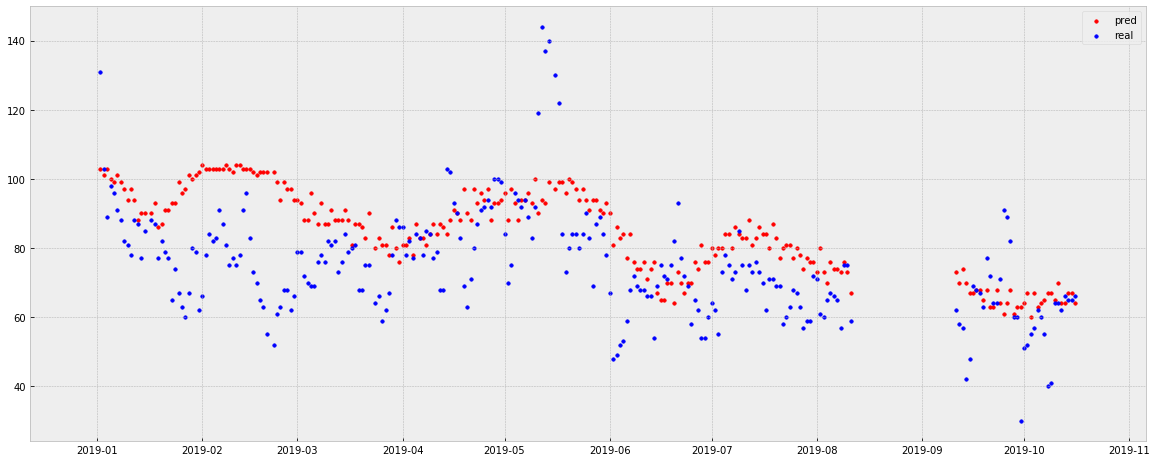

In [30]:
f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(20)
ax.scatter(df_comparison.index, df_comparison.imeca_pred, color='r',s=13, label='pred');
ax.scatter(df_comparison.index, df_comparison['Centro PM25'], color='b',s=13, label='real');
ax.legend(loc="upper right");

In [29]:
df_comparison.head()

,yhat_upper,imeca_pred,Centro PM25,categoria_pred,categoria_real,comparacion_imecas
ds,,,,,,
2019-01-02,80.769698,103,131,Mala,Mala,1
2019-01-03,79.659998,102,103,Mala,Mala,1
2019-01-04,81.033675,103,89,Mala,Regular,0
2019-01-05,76.455199,101,98,Mala,Regular,0
2019-01-06,73.947028,99,96,Regular,Regular,1


## Comparación modelo 2

### Predicción

In [115]:
df_pred2=pd.DataFrame(pred2[['ds','yhat_upper']])
df_pred2=df_pred2.set_index('ds')

In [116]:
df_pred2.head(10)

,yhat_upper
ds,
2019-01-02,84.159655
2019-01-03,83.602251
2019-01-04,85.204089
2019-01-05,79.797183
2019-01-06,78.961582
2019-01-07,76.790118
2019-01-08,79.037898
2019-01-09,75.777616
2019-01-10,74.303557


In [117]:
df_pred2.shape

(254, 1)

In [118]:
df_pred2.isnull().sum() #13 NANs
df_pred2=df_pred2.dropna()

In [119]:
df_pred2.shape

(254, 1)

In [120]:
df_pred2['imeca_pred']=imeca_calculation(df_pred2.yhat_upper)
df_pred2.head()

,yhat_upper,imeca_pred
ds,,
2019-01-02,84.159655,104
2019-01-03,83.602251,104
2019-01-04,85.204089,104
2019-01-05,79.797183,102
2019-01-06,78.961582,102


### Cuauh's IMECA real

In [121]:
cuauh_imeca_mean.head()

,Centro PM25
DATETIME,
2019-01-01,114.541667
2019-01-02,110.708333
2019-01-03,88.541667
2019-01-04,85.791667
2019-01-05,91.416667


In [122]:
df_comparison=df_pred2.join(cuauh_imeca_mean)[['yhat_upper','imeca_pred','Centro PM25']]
df_comparison.head(10)

,yhat_upper,imeca_pred,Centro PM25
ds,,,
2019-01-02,84.159655,104,110.708333
2019-01-03,83.602251,104,88.541667
2019-01-04,85.204089,104,85.791667
2019-01-05,79.797183,102,91.416667
2019-01-06,78.961582,102,87.250000
2019-01-07,76.790118,101,86.791667
2019-01-08,79.037898,102,82.166667
2019-01-09,75.777616,101,79.250000
2019-01-10,74.303557,99,71.166667


In [123]:
df_comparison['categoria_pred']=categorizando(df_comparison.imeca_pred)
df_comparison['categoria_real']=categorizando(df_comparison['Centro PM25'])
df_comparison['comparacion_imecas']=comparando_categorias(df_comparison.categoria_pred,df_comparison.categoria_real)
df_comparison.head(10)

,yhat_upper,imeca_pred,Centro PM25,categoria_pred,categoria_real,comparacion_imecas
ds,,,,,,
2019-01-02,84.159655,104,110.708333,Mala,Mala,1
2019-01-03,83.602251,104,88.541667,Mala,Regular,0
2019-01-04,85.204089,104,85.791667,Mala,Regular,0
2019-01-05,79.797183,102,91.416667,Mala,Regular,0
2019-01-06,78.961582,102,87.250000,Mala,Regular,0
2019-01-07,76.790118,101,86.791667,Mala,Regular,0
2019-01-08,79.037898,102,82.166667,Mala,Regular,0
2019-01-09,75.777616,101,79.250000,Mala,Regular,0
2019-01-10,74.303557,99,71.166667,Regular,Regular,1


In [124]:
df_comparison.comparacion_imecas.value_counts()

1    169
0     85
Name: comparacion_imecas, dtype: int64

In [125]:
169/254

0.6653543307086615

In [ ]:
df_comparison.head()